#### Example: The Lotka-Volterra Predator-Prey model

Imports to get the model up and running

In [1]:
import numpy as np
import gillespy2
from gillespy2.solvers.stochkit import StochKitSolver

Model definition

In [2]:
class LotkaVolterra(gillespy2.Model):
    def __init__(self, parameter_values=[1.0, 0.005, 0.6]):
        # initialize Model
        gillespy2.Model.__init__(self, name="Lotka-Volterra")

        # parameters
        params = parameter_values
        rate1 = gillespy2.Parameter(name='rate1', expression=params[0])
        rate2 = gillespy2.Parameter(name='rate2', expression=params[1])
        rate3 = gillespy2.Parameter(name='rate3', expression=params[2])
        self.add_parameter([rate1, rate2, rate3])

        # Species
        A = gillespy2.Species(name='A', initial_value=50)
        B = gillespy2.Species(name='B', initial_value=100)
        self.add_species([A, B])

        # reactions
        r1 = gillespy2.Reaction(name="r1", reactants={A: 1}, products={A: 2},
                                rate=rate1)

        r2 = gillespy2.Reaction(name="r2", reactants={A: 1, B: 1}, products={B: 2},
                                rate=rate2)

        r3 = gillespy2.Reaction(name="r3", reactants={B: 1}, products={},
                                rate=rate3)
        self.add_reaction([r1, r2, r3])
        self.timespan(np.linspace(0, 30, 30))

Instantiate the model and test responses

In [3]:
model = LotkaVolterra()

In [4]:
results = model.run(solver=StochKitSolver, show_labels=True, number_of_trajectories=1)

Plot responses

In [5]:
#%matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

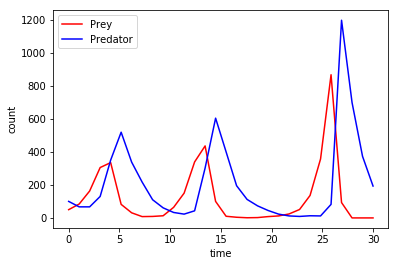

In [6]:
plt.plot(results[0]['time'], results[0]['A'],'-r', label='Prey')
plt.plot(results[0]['time'], results[0]['B'],'-b', label='Predator')
plt.xlabel('time')
plt.ylabel('count')
plt.legend(loc='best')

Create a dataset for inference

In [7]:
results = model.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=100)
# reshape
fixed_data = np.asarray([x.T for x in results])
# and remove timepoints array
fixed_data = fixed_data[:,1:, :]

Verify we have the data in correct dimensionality (num trajs/time series x num species x num time points/time steps)

In [8]:
fixed_data.shape

(100, 2, 30)

In [9]:
num_timestamps = fixed_data.shape[2]

Set up a dask cluster (or use multiprocessing)

In [10]:
#from dask.distributed import Client

In [11]:
#c = Client()

In [12]:
#c

Imports for inference

In [13]:
from sciope.utilities.priors import uniform_prior
from sciope.inference import abc_inference
from sklearn.metrics import mean_absolute_error
from sciope.utilities.summarystats import auto_tsfresh
from sciope.utilities.distancefunctions import naive_squared
from tsfresh.feature_extraction.settings import MinimalFCParameters

Define a simulator to be used as part of the inference task

In [14]:
# simulator
def sim_lv(param):
    lv_model = LotkaVolterra(parameter_values=param)
    sim_results = model.run(solver=StochKitSolver, show_labels=False, number_of_trajectories=1)
    tot_res = np.asarray([x.T for x in sim_results]) # reshape to (N, S, T)  
    tot_res = tot_res[:,1:, :] # should not contain timepoints
    tot_res = tot_res.reshape((1, 2, num_timestamps))
    return tot_res

Set up inference objects

In [15]:
dmin = [0.7, 0.001, 0.5]
dmax = [1.2, 0.005, 0.8]
lv_prior = uniform_prior.UniformPrior(np.asarray(dmin), np.asarray(dmax))

In [16]:
# summary statistics 
summ_func = auto_tsfresh.SummariesTSFRESH(corrcoef=True)

# distance function
ns = naive_squared.NaiveSquaredDistance()

In [17]:
abc_instance = abc_inference.ABC(fixed_data, sim_lv, epsilon=0.005, prior_function=lv_prior, 
                                 summaries_function=summ_func.compute, distance_function=ns)

In [18]:
abc_instance.compute_fixed_mean(chunk_size=2)

Perform inference

In [19]:
abc_results = abc_instance.infer(num_samples=50, batch_size=10, chunk_size=2)

In [20]:
abc_results

{'accepted_count': 50,
 'accepted_samples': [array([1.06736161, 0.00339261, 0.59223305]),
  array([1.1956943 , 0.00247776, 0.75699585]),
  array([0.9225631 , 0.00159232, 0.55707817]),
  array([1.08507793, 0.00412532, 0.58061342]),
  array([1.07954557, 0.00251019, 0.78542656]),
  array([0.95270868, 0.00278082, 0.65309163]),
  array([0.93758079, 0.00411494, 0.77033663]),
  array([1.03791646, 0.00194151, 0.51534245]),
  array([1.08419797, 0.0023436 , 0.70222973]),
  array([0.83372882, 0.00256858, 0.66613492]),
  array([0.71516727, 0.00393198, 0.79323961]),
  array([1.06651046, 0.00477834, 0.64985035]),
  array([1.00263327, 0.00219175, 0.69979363]),
  array([0.82216955, 0.00144944, 0.69264316]),
  array([1.04588007, 0.00232506, 0.74040126]),
  array([0.87895632, 0.00129169, 0.64404747]),
  array([1.01178058, 0.00225713, 0.56233686]),
  array([0.76343247, 0.00232591, 0.57955008]),
  array([0.76990314, 0.0011222 , 0.66540058]),
  array([1.0918517 , 0.00395498, 0.50083125]),
  array([0.880183

Analyse results, plot the inferred response

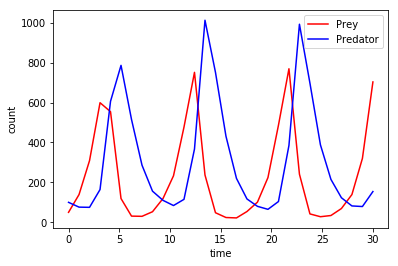

In [21]:
test_model = LotkaVolterra(parameter_values=abc_results['inferred_parameters'])
test_res = test_model.run(solver=StochKitSolver, show_labels=True)
plt.plot(test_res[0]['time'], test_res[0]['A'],'-r', label='Prey')
plt.plot(test_res[0]['time'], test_res[0]['B'],'-b', label='Predator')
plt.xlabel('time')
plt.ylabel('count')
plt.legend(loc='best')

Calculate error metrics w.r.t. inferred parameters

In [22]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [23]:
true_params = np.asarray([1.0, 0.005, 0.6])
print('Mean Absolute Error (MAE) in inferred parameters =', mean_absolute_error(true_params, np.asarray(abc_results['inferred_parameters'])))
print('Mean Absolute Percentage Error (MAPE) in inferred parameters =', mean_absolute_percentage_error(true_params, np.asarray(abc_results['inferred_parameters'])))


Mean Absolute Error (MAE) in inferred parameters = 0.02545684936395738
Mean Absolute Percentage Error (MAPE) in inferred parameters = 17.3004345480034


Calculate error metrics w.r.t. responses

In [24]:
# simulate a trajectory at the true parameter point
# and get the summary stats
sim_true = sim_lv(true_params)
sim_inf = sim_lv(abc_results['inferred_parameters'])
sum_stats_true = summ_func.compute(sim_true)
sum_stats_inf = summ_func.compute(sim_inf)


# calculate MAE and MAPE
mae_response = mean_absolute_error(sum_stats_true, sum_stats_inf)
mape_response = mean_absolute_percentage_error(sum_stats_true, sum_stats_inf)

print('MAE w.r.t. responses =', mae_response)
print('MAPE w.r.t. responses =', mape_response)

MAE w.r.t. responses = 587.7511928125862
MAPE w.r.t. responses = 28.66551535494632
